## Теоретическая часть

1. Вспомним прошлый вебинар, мы рассматривали User-User рекомендации и Item-Item рекомендации. Чем они отличаются и чем они похожи? Если есть функция item_item_rec(interaction_matrix). Можно ли использовать эту функцию для user_user_rec?  
В чем принципиальные отличия item-item рекомендаций от ALS?


User-User предсказвает рейтинг тещего пользователя как некоторую линейную комбинацию рейтинга К других пользователей. Товары явл. признаками для пользователей.
Item-Item тоже сомое, только ищем похожие товары. Пользователи являются признаками для товаров.

Если есть функция item_item_rec(interaction_matrix). Можно ли использовать эту функцию для user_user_rec? 
Вопрос непонятен. Если есть обученая модель для item_item_rec, то под user_user_rec модель нужно переобучать.

ALS в отличие от item-item дополнит пропуски в матрице 𝑐𝑢𝑖, item-item будет работать с имеющейся rui. Точнее ALS используют для оптимизации матрици весов ошибок.

2. Приведите 3 примера весов (те, которых не было на вебинаре: сумма покупок, количество покупок - неинтересно) user-item матрицы для задачи рекомендаций товаров 


Кол-во коментариев

Оценка товара другими пользователями

кол-во простмотров

срок гарантии

3. Какие ограничения есть у ALS? (Тип информации, линейность/нелинейность факторов и т д)


ALS учитывает только линейные взаимодействия факторов

Что бы алс работала каждый товар должен купить хоть один пользователь, хоть один раз. те. новый товар (ниразу не входящий в оборот) алс не обработает.

4. Мы рассматривали bm_25_weight. 
Опишите, как он работает. Как сделать рекомендации только на основе bm_25? (Можно и нужно пользоваться любыми источниками, приложите на них ссылки). Какие еще способы перевзвешивания user-item матрицы Вы знаете / можете предложить (ещё 2-3 способа)?

bm_25_weight - это функция ранжирования, используемая поисковыми системами для упорядочивания документов по их релевантности данному поисковому запросу. 

https://habr.com/ru/post/162937/
https://ru.wikipedia.org/wiki/Okapi_BM25
https://semantica.in/blog/algoritm-bm25.html

Принцип работы: Документ анализируется, значения попадают в формулу, где сравниваются показатели относительно других документов и в конечном итоге выдается оценка, которая влияет на ранжирование страницы в поисковой выдаче.

Перевзвесить можно:
 Косинусное сходство и CosineRecommender
 TF_IDF

## Практическая часть


In [2]:
import implicit

In [3]:
# import data
# utils functions like in webinar

### Подбор матрицы $c_{ui}$
Попробуйте различные варианты матрицы весов (3+ вариантов). Обучите алгоритм для различных $C$. В качестве результата приведите таблицу: матрица весов - результат на train и validation.
Сделате качественные выводы.


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Для работы с матрицами
from scipy.sparse import csr_matrix

# Матричная факторизация
from implicit.als import AlternatingLeastSquares
from implicit.nearest_neighbours import bm25_weight, tfidf_weight

# Функции из 1-ого вебинара
import os, sys
module_path = os.path.abspath(os.path.join(os.pardir))
if module_path not in sys.path:
    sys.path.append(module_path)

In [4]:
def precision_at_k(recommended_list, bought_list, k=5):
    
    bought_list = np.array(bought_list)
    recommended_list = np.array(recommended_list)
    
    bought_list = bought_list  # Тут нет [:k] !!
    recommended_list = recommended_list[:k]
    
    flags = np.isin(bought_list, recommended_list)
    #print(flags)
    
    
    precision = flags.sum() / len(recommended_list)
    
    
    return precision

In [8]:
data = pd.read_csv('../retail_train/retail_train.csv')

data.columns = [col.lower() for col in data.columns]
data.rename(columns={'household_key': 'user_id',
                    'product_id': 'item_id'},
           inplace=True)


test_size_weeks = 3

data_train = data[data['week_no'] < data['week_no'].max() - test_size_weeks]
data_test = data[data['week_no'] >= data['week_no'].max() - test_size_weeks]

data_train.head(2)

,user_id,basket_id,day,item_id,quantity,sales_value,store_id,retail_disc,trans_time,week_no,coupon_disc,coupon_match_disc
0,2375,26984851472,1,1004906,1,1.39,364,-0.6,1631,1,0.0,0.0
1,2375,26984851472,1,1033142,1,0.82,364,0.0,1631,1,0.0,0.0


In [10]:
item_features = pd.read_csv('../product.csv')
item_features.columns = [col.lower() for col in item_features.columns]
item_features.rename(columns={'product_id': 'item_id'}, inplace=True)

item_features.head(2)

,item_id,manufacturer,department,brand,commodity_desc,sub_commodity_desc,curr_size_of_product
0,25671,2,GROCERY,National,FRZN ICE,ICE - CRUSHED/CUBED,22 LB
1,26081,2,MISC. TRANS.,National,NO COMMODITY DESCRIPTION,NO SUBCOMMODITY DESCRIPTION,


In [11]:
result = data_test.groupby('user_id')['item_id'].unique().reset_index()
result.columns=['user_id', 'actual']
result.head(2)

,user_id,actual
0,1,"[821867, 834484, 856942, 865456, 889248, 90795..."
1,3,"[835476, 851057, 872021, 878302, 879948, 90963..."


In [12]:
popularity = data_train.groupby('item_id')['quantity'].sum().reset_index()
popularity.rename(columns={'quantity': 'n_sold'}, inplace=True)

top_5000 = popularity.sort_values('n_sold', ascending=False).head(5000).item_id.tolist()

In [14]:
# Заведем фиктивный item_id (если юзер покупал товары из топ-5000, то он "купил" такой товар)
data_train.loc[~data_train['item_id'].isin(top_5000), 'item_id'] = 999999

user_item_matrix = pd.pivot_table(data_train, 
                                  index='user_id', columns='item_id', 
                                  values='quantity', # Можно пробоват ьдругие варианты
                                  aggfunc='count', 
                                  fill_value=0
                                 )

user_item_matrix = user_item_matrix.astype(float) # необходимый тип матрицы для implicit

# переведем в формат saprse matrix
sparse_user_item = csr_matrix(user_item_matrix).tocsr()

userids = user_item_matrix.index.values
itemids = user_item_matrix.columns.values

matrix_userids = np.arange(len(userids))
matrix_itemids = np.arange(len(itemids))

id_to_itemid = dict(zip(matrix_itemids, itemids))
id_to_userid = dict(zip(matrix_userids, userids))

itemid_to_id = dict(zip(itemids, matrix_itemids))
userid_to_id = dict(zip(userids, matrix_userids))

user_item_matrix.head(3)

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


item_id,202291,397896,420647,480014,545926,707683,731106,818980,819063,819227,...,15778533,15831255,15926712,15926775,15926844,15926886,15927403,15927661,15927850,16809471
user_id,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [15]:
%%time

csr_mat = csr_matrix(user_item_matrix).T.tocsr()

model = AlternatingLeastSquares(factors=100, #k
                                regularization=0.001,
                                iterations=15, 
                                calculate_training_loss=True, 
                                num_threads=4)

model.fit(csr_matrix(user_item_matrix).T.tocsr(),  # На вход item-user matrix
          show_progress=True)

recs = model.recommend(userid=userid_to_id[2],  # userid - id от 0 до N
                        user_items=csr_matrix(user_item_matrix).tocsr(),   # на вход user-item matrix
                        N=5, # кол-во рекомендаций 
                        filter_already_liked_items=False, 
                        filter_items=None, 
                        recalculate_user=True)


Wall time: 4.7 s


In [16]:
def get_recommendations(user, model, N=5):
    res = [id_to_itemid[rec[0]] for rec in 
                    model.recommend(userid=userid_to_id[user], 
                                    user_items=sparse_user_item,   # на вход user-item matrix
                                    N=N, 
                                    filter_already_liked_items=False, 
                                    filter_items=None, 
                                    recalculate_user=True)]
    return res

In [18]:
statistic = dict()

In [19]:
result['als'] = result['user_id'].apply(lambda x: get_recommendations(x, model=model, N=5))
statistic['general'] = result.apply(lambda row: precision_at_k(row['als'], row['actual']), axis=1).mean()

In [23]:
%%time

user_item_matrix = tfidf_weight(user_item_matrix.T).T  # Применяется к item-user матрице ! 

model = AlternatingLeastSquares(factors=100, 
                                regularization=0.001,
                                iterations=15, 
                                calculate_training_loss=True, 
                                num_threads=4)

model.fit(csr_matrix(user_item_matrix).T.tocsr(),  # На вход item-user matrix
          show_progress=True)

result['als_tfidf'] = result['user_id'].apply(lambda x: get_recommendations(x, model=model, N=5))

statistic['tf-idf'] = result.apply(lambda row: precision_at_k(row['als_tfidf'], row['actual']), axis=1).mean()


Wall time: 30.1 s


In [25]:
# Заведем фиктивный item_id (если юзер покупал товары из топ-5000, то он "купил" такой товар)
data_train.loc[~data_train['item_id'].isin(top_5000), 'item_id'] = 999999

user_item_matrix = pd.pivot_table(data_train, 
                                  index='user_id', columns='item_id', 
                                  values='quantity', # Можно пробоват ьдругие варианты
                                  aggfunc='count', 
                                  fill_value=0
                                 )

user_item_matrix = user_item_matrix.astype(float) # необходимый тип матрицы для implicit

# переведем в формат saprse matrix
sparse_user_item = csr_matrix(user_item_matrix).tocsr()

user_item_matrix.head(3)

user_item_matrix = bm25_weight(user_item_matrix.T).T  # Применяется к item-user матрице ! 

model = AlternatingLeastSquares(factors=100, 
                                regularization=0.001,
                                iterations=15, 
                                calculate_training_loss=True, 
                                num_threads=4) # K - кол-во билжайших соседей

model.fit(csr_matrix(user_item_matrix).T.tocsr(),  # На вход item-user matrix
          show_progress=True)

result['als_bm25'] = result['user_id'].apply(lambda x: get_recommendations(x, model=model, N=5))

statistic['bm25'] = result.apply(lambda row: precision_at_k(row['als_bm25'], row['actual']), axis=1).mean()

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


In [26]:
statistic

{'general': 0.15925563173359242,
 'tf-idf': 0.16865817825660892,
 'bm25': 0.19333986287952715}

In [54]:
? AlternatingLeastSquares

In [36]:
statistic.

dict_values([0.15925563173359242, 0.16865817825660892, 0.19333986287952715])

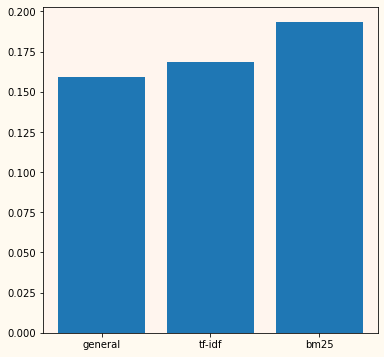

In [40]:
fig, ax = plt.subplots()

ax.bar(statistic.keys(), statistic.values())

ax.set_facecolor('seashell')
fig.set_facecolor('floralwhite')
fig.set_figwidth(6)    #  ширина Figure
fig.set_figheight(6)    #  высота Figure

plt.show()

### Оптимизация гипперпараметров
Для лучшей матрицы весов из первого задания подберите оптимальные $\lambda$ и n_factors. Подбор можно делать вручную (цикл в цикле, аналог sklearn.GridSearch, или случайно - sklearn.GridSearch). Или Вы можете воспользоваться библиотеками для автоматического подбора гипперпараметров (любые на Ваш вкус). В качестве результата постройте графики:
1. Значение параметра - время обучения 
2. Значение параметра - качество train, качество validation  

Сделайте качественные выводы

In [55]:
import time

statistic_precision = list()
statistic_time = list()
n_factors = np.arange(50, 350, 50) 

result = data_test.groupby('user_id')['item_id'].unique().reset_index()
result.columns=['user_id', 'actual']
result.head(2)

for n in n_factors:
    # Заведем фиктивный item_id (если юзер покупал товары из топ-5000, то он "купил" такой товар)
    data_train.loc[~data_train['item_id'].isin(top_5000), 'item_id'] = 999999

    user_item_matrix = pd.pivot_table(data_train, 
                                      index='user_id', columns='item_id', 
                                      values='quantity', # Можно пробоват ьдругие варианты
                                      aggfunc='count', 
                                      fill_value=0
                                     )

    user_item_matrix = user_item_matrix.astype(float) # необходимый тип матрицы для implicit

    # переведем в формат saprse matrix
    sparse_user_item = csr_matrix(user_item_matrix).tocsr()

    user_item_matrix.head(3)

    user_item_matrix = bm25_weight(user_item_matrix.T).T  # Применяется к item-user матрице ! 

    start_time = time.time()
    
    model = AlternatingLeastSquares(factors=n, 
                                    regularization=0.001,
                                    iterations=15, 
                                    calculate_training_loss=True, 
                                    num_threads=4) # K - кол-во билжайших соседей

    model.fit(csr_matrix(user_item_matrix).T.tocsr(),  # На вход item-user matrix
              show_progress=True)
    
    end_time = time.time()

    result[f'factors={n}'] = result['user_id'].apply(lambda x: get_recommendations(x, model=model, N=5))

    statistic_precision.append(result.apply(lambda row: precision_at_k(row[f'factors={n}'], row['actual']), axis=1).mean())
    statistic_time.append(end_time - start_time)

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


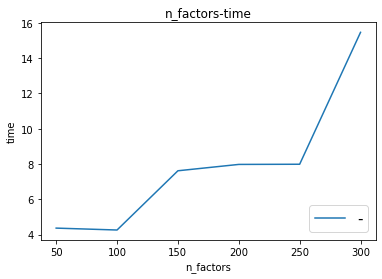

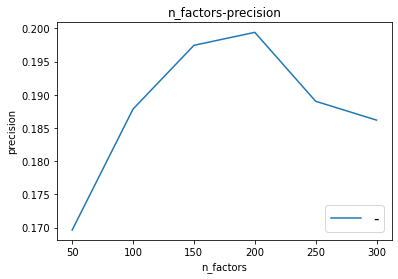

In [65]:
#------------------------------------------------------------------------------
#
plt.plot(n_factors, statistic_time, label='-')

plt.xlabel('n_factors')
plt.ylabel('time')
plt.title('n_factors-time')
plt.legend(loc="lower right", prop={'size': 15})
plt.show()
#------------------------------------------------------------------------------
plt.plot(n_factors, statistic_precision, label='-')

plt.xlabel('n_factors')
plt.ylabel('precision')
plt.title('n_factors-precision')
plt.legend(loc="lower right", prop={'size': 15})
plt.show()

In [66]:
import time

statistic_precision = list()
statistic_time = list()
n_regularization = [10, 1, 0.1, 0.01, 0.001, 0.0001]

result = data_test.groupby('user_id')['item_id'].unique().reset_index()
result.columns=['user_id', 'actual']
result.head(2)

for n in n_regularization:
    # Заведем фиктивный item_id (если юзер покупал товары из топ-5000, то он "купил" такой товар)
    data_train.loc[~data_train['item_id'].isin(top_5000), 'item_id'] = 999999

    user_item_matrix = pd.pivot_table(data_train, 
                                      index='user_id', columns='item_id', 
                                      values='quantity', # Можно пробоват ьдругие варианты
                                      aggfunc='count', 
                                      fill_value=0
                                     )

    user_item_matrix = user_item_matrix.astype(float) # необходимый тип матрицы для implicit

    # переведем в формат saprse matrix
    sparse_user_item = csr_matrix(user_item_matrix).tocsr()

    user_item_matrix.head(3)

    user_item_matrix = bm25_weight(user_item_matrix.T).T  # Применяется к item-user матрице ! 

    start_time = time.time()
    
    model = AlternatingLeastSquares(factors=200, 
                                    regularization=n,
                                    iterations=15, 
                                    calculate_training_loss=True, 
                                    num_threads=4) # K - кол-во билжайших соседей

    model.fit(csr_matrix(user_item_matrix).T.tocsr(),  # На вход item-user matrix
              show_progress=True)
    
    end_time = time.time()

    result[f'factors={n}'] = result['user_id'].apply(lambda x: get_recommendations(x, model=model, N=5))

    statistic_precision.append(result.apply(lambda row: precision_at_k(row[f'factors={n}'], row['actual']), axis=1).mean())
    statistic_time.append(end_time - start_time)

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


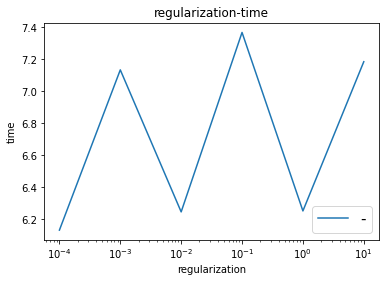

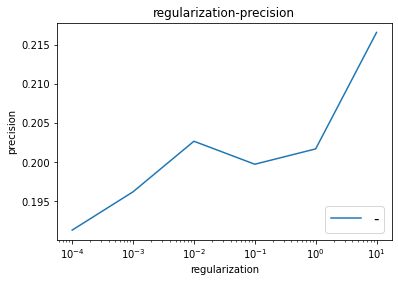

In [71]:
#------------------------------------------------------------------------------
#
plt.plot(n_regularization, statistic_time, label='-')

plt.xlabel('regularization')
plt.ylabel('time')
plt.title('regularization-time')
plt.legend(loc="lower right", prop={'size': 15})
plt.xscale('log')
plt.show()
#------------------------------------------------------------------------------
plt.plot(n_regularization, statistic_precision, label='-')

plt.xlabel('regularization')
plt.ylabel('precision')
plt.title('regularization-precision')
plt.legend(loc="lower right", prop={'size': 15})
plt.xscale('log')
plt.show()

**P.S.** Не пишите отписки в качестве выводов. Мне интресены Ваши рассуждения, трудности, с которыми Вы сталкнулись и что-то, что Вас удивило. Если выводы контринтуитивны - напишите об этом, в этом нет ничего страшного!

In [72]:
? AlternatingLeastSquares

При увеличении количества скрытых факторов для вычисления увеличится время работы алгоритма. Самый оптимальный качество модели при 200 скрытых факторов.
Коэффициенты регуляризации не влияют на время обучения модели. При увеличении коэффициентов регуляризации точность возрастала, но не начала уменьшаться. Нужно увеличить коэффициенты регуляризации еще больше.